# Temporal Regression with LightGBM

Data preprocessing:
1. Categorical features have been Encoded
2. Text columns and columns that have no effect on the model have been dropped
3. Added 7 lagged values
4. Performed data imputation
5. Identified and treated outlier

Model training:
1. Trained a LightGBM model using GridSearchCV

Time Series Analysis:
1. We compared the performance of the model with and without including the weather features. And observed that weather data slightly improved model performance.

|  | MAE | MSE | MAPE | RMSE |
| --- | --- | --- | --- | --- |
| Model without weather | 38.401318 | 2805.280708 | 0.055510 | 52.964901 |
| Model with weather | 37.860209 | 2654.924996 | 0.054174 | 51.525964 |

2. Further, we investigated to which degree weather features affect individual offenses. According to our results 'Motor Vehicle Theft' is the crime most affected by weather, while 'Fraud Offenses' and 'Drug/Narcotic Offenses' are impacted very little by weather, which confirms our intuition:

| Crime type | Weather features importance |
| --- | --- |
| Motor Vehicle Theft | 0.2243 |
| Robbery | 0.2046 |
| Larceny/Theft Offenses | 0.1826 |
| Burglary/Breaking & Entering | 0.086 |
| Assault Offenses | 0.083 |
| Destruction/Damage/Vandalism of Property | 0.0754 |
| Drug/Narcotic Offenses | 0.057 |
| Fraud Offenses | 0.041 |

3. Then we analyzed in more detail the influence of weather on individual crime types

3.1. Motor Vehicle Theft

The higher precipitation values affect crime rates in a positive way, which can be explained because streets are less busy during rain and rain also covers noise to a certain degree. In addition, during higher moon phases crime rates are more increased.
We conclude that bad weather and more light during nighttime help this type of crime.

3.2. Larceny/Theft Offenses

Higher values of precipitation and windspeed impact Larceny/Theft Offenses in a negative way.

3.3. Assault Offenses

We see here that all temperature-related features are correlated to the crime rate, and the explanation is that these features as well as Assault Offenses display a clear seasonal pattern.

4. Conclusion

In conclusion, using a machine learning model and the data available we can see that certain crime types are affected by bad weather in a positive or negative way and that temperature levels also play a role in crime rates. But in order to determine a correlation between climate change and crime rates, we'd need higher granularity data as well as more accurate statistical tests.

### Import modules

In [1328]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Load data

In [1329]:
df = pd.read_csv('daily crime numbers and weather data for time series analysis.csv', index_col='date', parse_dates=['date'])
df.shape

(4960, 73)

In [1330]:
df.columns

Index(['Kidnapping/Abduction', 'Sex Offenses, Forcible', 'Robbery',
       'Assault Offenses', 'Arson', 'Extortion/Blackmail',
       'Burglary/Breaking & Entering', 'Larceny/Theft Offenses',
       'Motor Vehicle Theft', 'Counterfeiting/Forgery', 'Fraud Offenses',
       'Embezzlement', 'Stolen Property Offenses',
       'Destruction/Damage/Vandalism of Property', 'Drug/Narcotic Offenses',
       'Sex Offenses, Nonforcible', 'Pornography/Obscene Material',
       'Gambling Offenses', 'Prostitution Offenses', 'Bribery',
       'Weapon Law Violations', 'Human Trafficking or Kidnapping/Abduction',
       'Animal Cruelty', 'Homicide Offenses', 'Bad Checks',
       'Curfew/Loitering/Vagrancy Violations', 'Disorderly Conduct',
       'Driving Under the Influence', 'Drunkenness',
       'Family Offenses, Nonviolent', 'Liquor Law Violations', 'Peeping Tom',
       'Runaway', 'Trespass of Real Property', 'All Other Offenses',
       'Offense Count', 'week', 'month', 'year', 'mon_year', 'season

In [1331]:
def visualize_time_series(column, graph_title, graph_ylabel):
    fig, ax = plt.subplots(figsize=(15, 4))

    df.plot(y=column, ax=ax, label='Dataset', title=graph_title, linewidth=1)

    plt.xlabel("Date")
    plt.ylabel(graph_ylabel)
    plt.show()

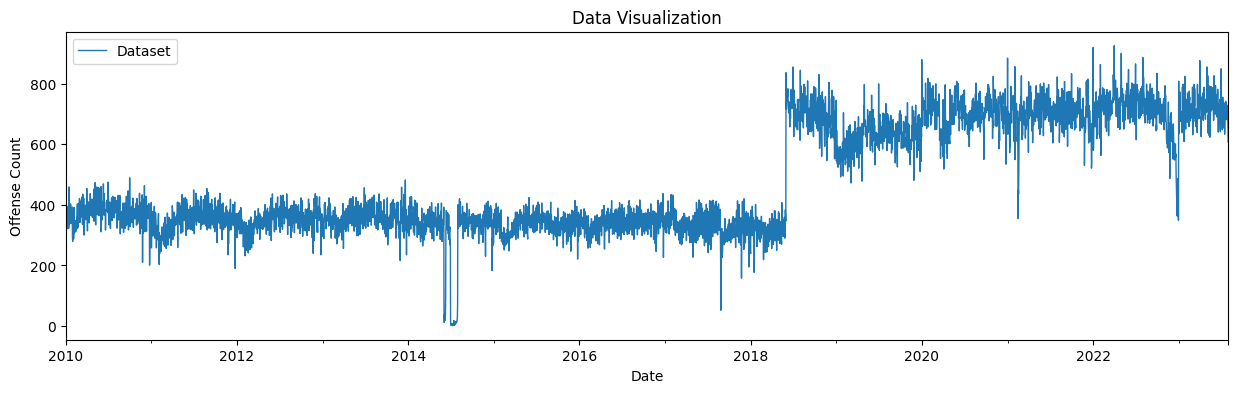

In [1332]:
visualize_time_series('Offense Count', 'Data Visualization', 'Offense Count')

## Feature engineering

In [1333]:
# null values
counts = df.isnull().sum()
print(counts.sort_values(ascending=False))

solarenergy                                  365
solarradiation                               365
uvindex                                      365
precip                                         0
humidity                                       0
                                            ... 
Bad Checks                                     0
Homicide Offenses                              0
Animal Cruelty                                 0
Human Trafficking or Kidnapping/Abduction      0
stations                                       0
Length: 73, dtype: int64


- Data imputation - A full year (2015) worth of data is missing for solarenergy, solarradiation, and uvindex

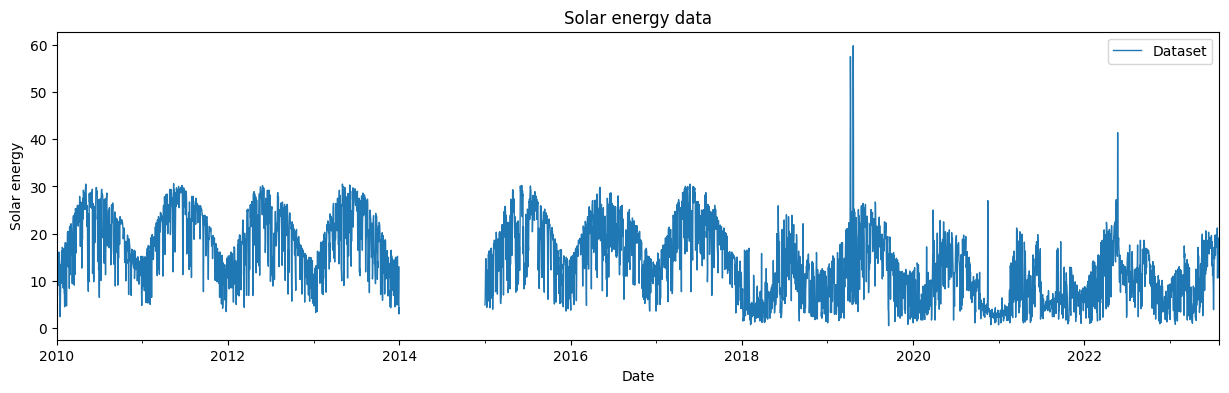

In [1334]:
visualize_time_series('solarenergy', 'Solar energy data', 'Solar energy')

In [1335]:
# Fill missing data with values from the previous year
df = df.fillna(df.shift(365))

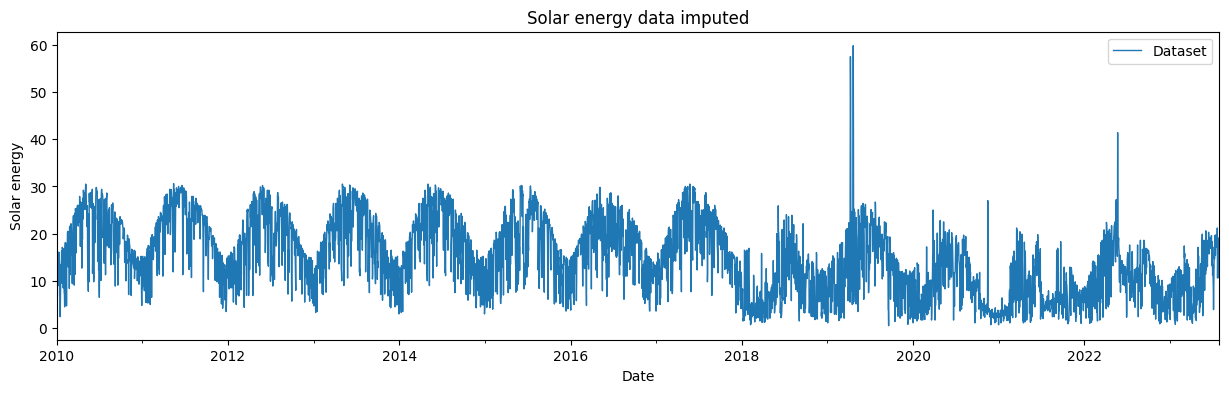

In [1336]:
visualize_time_series('solarenergy', 'Solar energy data imputed', 'Solar energy')

- Outlier treatment

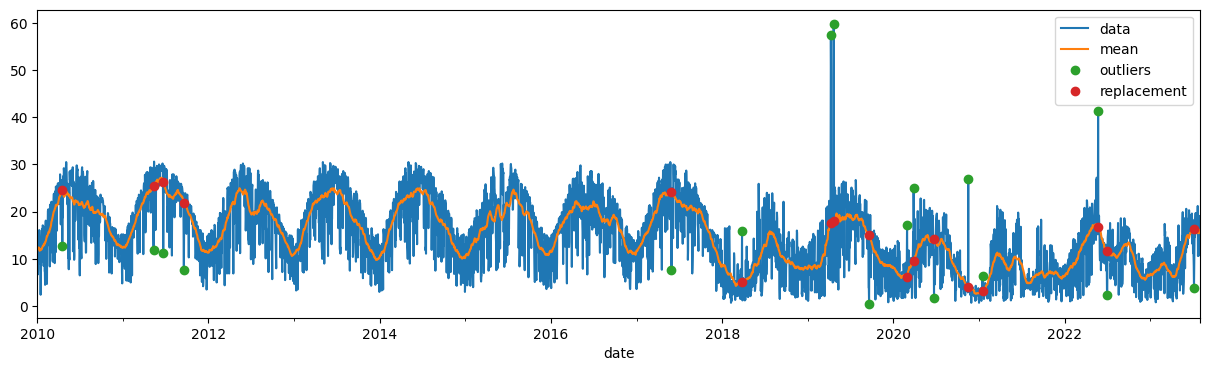

In [1337]:
# outlier detection and treatment using zscore
def zscore(s, window, thresh=3, return_all=False):
    roll = s.rolling(window=window, min_periods=1, center=True)
    avg = roll.mean()
    std = roll.std(ddof=0)
    z = s.sub(avg).div(std)   
    m = z.between(-thresh, thresh)
    
    if return_all:
        return z, avg, std, m
    return s.where(m, avg)

z, avg, std, m = zscore(df['solarenergy'], window=50, return_all=True)

plt.subplots(figsize=(15, 4))

df['solarenergy'].plot(label='data')
avg.plot(label='mean')
df.loc[~m, 'solarenergy'].plot(label='outliers', marker='o', ls='')
avg[~m].plot(label='replacement', marker='o', ls='')
plt.legend()
plt.show()

In [1338]:
df['solarenergy'] = zscore(df['solarenergy'], window=50, return_all=False)
df['solarradiation'] = zscore(df['solarradiation'], window=50, return_all=False)

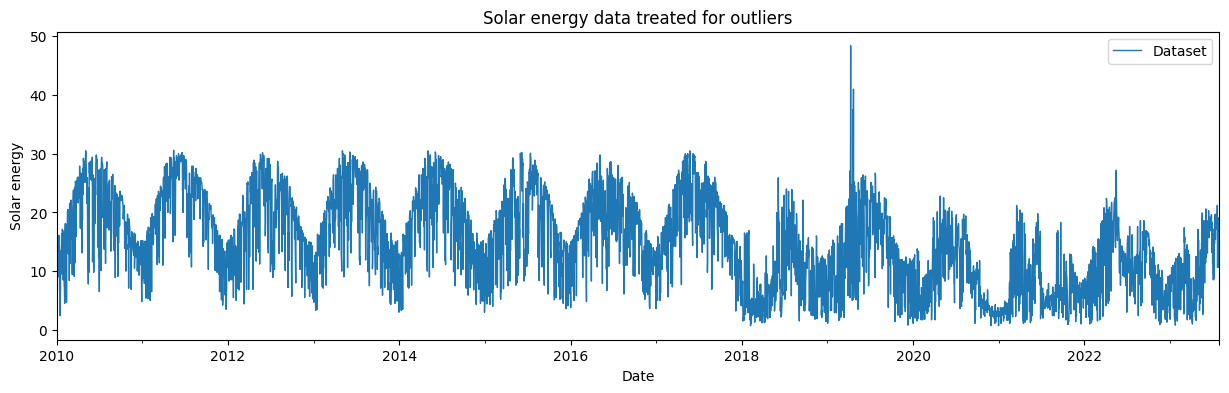

In [1339]:
visualize_time_series('solarenergy', 'Solar energy data treated for outliers', 'Solar energy')

In [1340]:
# using sunrise and sunset to create daytime
# resulted in obtaining worse results
# df['daytime'] = ((pd.to_datetime(df['sunset'])-pd.to_datetime(df['sunrise'])).dt.total_seconds() / 60).astype(int)

- Add lag features

Time series are characterized by the time-related dependenceies between values. To make use of this aspect in our model we will integrate a number of past values of the target variable as input features. We 7 of the most recent past values as this captures most of the past data information.

In [1341]:
def create_lag_features(df, lags=2):
  y = df.loc[:, 'Offense Count']
  for lag in range(lags):
    df[f"lag_{lag + 1}"] = y.shift(lag + 1)
  return df

df = create_lag_features(df, lags=7)

- Encode categorical data
- Drop text columns and columns that have no impact on the model

In [1343]:
from sklearn.preprocessing import LabelEncoder

# "OneHotEncode" categorial fetures
def encodeCategoricalFeatures(main_df, includeWeather=True):
    df = main_df.copy()

    if includeWeather:
        columns = ["week", "season", "icon", "preciptype", "conditions"]
    else:
        columns = ["week", "season"]

    dummies = pd.get_dummies(df[columns])
    df = pd.concat([df, dummies], axis='columns')
    
    return df

# drop cols
def dropFeatures(main_df, includeWeather=True):
    df = main_df.copy()
    cols = [
        'week',
        'season',
        'icon',
        'mon_year',
        'preciptype',
        'conditions',
        'sunrise',
        'sunset',
        'conditions',
        'description',
        'stations',
        'snow',
        'snowdepth',
        'precipprob',
        'winddir',
        'windgust',
        'dew'
    ]
    if includeWeather==False:
        cols = cols + ['tempmax', 'tempmin', 'temp',
       'feelslikemax', 'feelslikemin', 'feelslike', 'dew', 'humidity',
       'precip', 'precipprob', 'precipcover', 'preciptype', 'snow',
       'snowdepth', 'windgust', 'windspeed', 'winddir', 'sealevelpressure',
       'cloudcover', 'visibility', 'solarradiation', 'solarenergy', 'uvindex',
       'sunrise', 'sunset', 'moonphase', 'conditions', 'description', 'icon',
       'stations']
        
    df.drop(columns=cols, inplace=True)
    return df

## Modeling without weather features

In [1344]:
df_without_weather = (df
      .pipe(encodeCategoricalFeatures, includeWeather=False)
      .pipe(dropFeatures, includeWeather=False)
)

In [1345]:
df_without_weather.columns

Index(['Kidnapping/Abduction', 'Sex Offenses, Forcible', 'Robbery',
       'Assault Offenses', 'Arson', 'Extortion/Blackmail',
       'Burglary/Breaking & Entering', 'Larceny/Theft Offenses',
       'Motor Vehicle Theft', 'Counterfeiting/Forgery', 'Fraud Offenses',
       'Embezzlement', 'Stolen Property Offenses',
       'Destruction/Damage/Vandalism of Property', 'Drug/Narcotic Offenses',
       'Sex Offenses, Nonforcible', 'Pornography/Obscene Material',
       'Gambling Offenses', 'Prostitution Offenses', 'Bribery',
       'Weapon Law Violations', 'Human Trafficking or Kidnapping/Abduction',
       'Animal Cruelty', 'Homicide Offenses', 'Bad Checks',
       'Curfew/Loitering/Vagrancy Violations', 'Disorderly Conduct',
       'Driving Under the Influence', 'Drunkenness',
       'Family Offenses, Nonviolent', 'Liquor Law Violations', 'Peeping Tom',
       'Runaway', 'Trespass of Real Property', 'All Other Offenses',
       'Offense Count', 'month', 'year', 'is_holiday', 'is_weekend',

### Train / test split

In [1346]:
# split df into train and test
num_train = int(len(df_without_weather)*0.8)

train_without_weather = df_without_weather[:num_train]
test_without_weather = df_without_weather[num_train:]

In [1348]:
y_train_all = train_without_weather.iloc[:, :36]
y_test_all = test_without_weather.iloc[:, :36]

train_without_weather = train_without_weather.iloc[:, 36:]
test_without_weather = test_without_weather.iloc[:, 36:]

X_train_without_weather = train_without_weather.values
X_test_without_weather = test_without_weather.values

In [1349]:
# pick one target value
y_train = y_train_all['Offense Count'].values
y_test = y_test_all['Offense Count'].values

## LightGB Model

### Training

In [1350]:
import lightgbm as lgb
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

# LGBM
cv_split = TimeSeriesSplit(n_splits=4, test_size=100)
model = lgb.LGBMRegressor()
parameters = {
    "max_depth": [3, 4, 5, 6],
    "num_leaves": [10, 20, 30, 40],
    "learning_rate": [0.01, 0.05, 0.1, 0.2],
    "n_estimators": [50, 100, 120],
    "colsample_bytree": [0.5, 0.7, 1]
}

grid_search = GridSearchCV(estimator=model, cv=cv_split, param_grid=parameters)
grid_search.fit(X_train_without_weather, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=4, test_size=100),
             estimator=LGBMRegressor(),
             param_grid={'colsample_bytree': [0.7], 'learning_rate': [0.2],
                         'max_depth': [6], 'n_estimators': [50],
                         'num_leaves': [10]})

### Evaluation

In [1352]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error,\
  mean_squared_error

def evaluate_model(y_test, pred):
  data = [
    {
      'MAE': mean_absolute_error(y_test, pred), 
      'MSE': mean_squared_error(y_test, pred), 
      'MAPE': mean_absolute_percentage_error(y_test, pred),
      'RMSE': np.sqrt(mean_squared_error(y_test, pred))
    }
  ]
  return pd.DataFrame(data)
  
def plot_predictions(title, ax, testing_dates, y_test, pred):
  df_test = pd.DataFrame({"date": testing_dates, "actual": y_test, "prediction": pred })
  df_test.plot(ax=ax, label="Actual", x="date", y="actual", linewidth=2)
  df_test.plot(ax=ax, label="Prediction", x="date", y="prediction", linewidth=2)
  plt.legend(["Actual", "Prediction"])
  ax.set_title(title)
  # plt.show()

In [1353]:
# Evaluating GridSearch results
pred_without_weather = grid_search.predict(X_test_without_weather)
evaluation_without_weather = evaluate_model(y_test, pred_without_weather)
evaluation_without_weather.index = ["Model without weather"]

## Model with weather features

In [1354]:
df = (df
      .pipe(encodeCategoricalFeatures)
      .pipe(dropFeatures)
)

In [1355]:
df.columns

Index(['Kidnapping/Abduction', 'Sex Offenses, Forcible', 'Robbery',
       'Assault Offenses', 'Arson', 'Extortion/Blackmail',
       'Burglary/Breaking & Entering', 'Larceny/Theft Offenses',
       'Motor Vehicle Theft', 'Counterfeiting/Forgery', 'Fraud Offenses',
       'Embezzlement', 'Stolen Property Offenses',
       'Destruction/Damage/Vandalism of Property', 'Drug/Narcotic Offenses',
       'Sex Offenses, Nonforcible', 'Pornography/Obscene Material',
       'Gambling Offenses', 'Prostitution Offenses', 'Bribery',
       'Weapon Law Violations', 'Human Trafficking or Kidnapping/Abduction',
       'Animal Cruelty', 'Homicide Offenses', 'Bad Checks',
       'Curfew/Loitering/Vagrancy Violations', 'Disorderly Conduct',
       'Driving Under the Influence', 'Drunkenness',
       'Family Offenses, Nonviolent', 'Liquor Law Violations', 'Peeping Tom',
       'Runaway', 'Trespass of Real Property', 'All Other Offenses',
       'Offense Count', 'month', 'year', 'is_holiday', 'is_weekend',

### Train / test split

In [1356]:
# Split df_final into train and test
num_train = int(len(df)*0.8)

train = df[:num_train]
test = df[num_train:]

In [1357]:
train = train.iloc[:, 36:]
test = test.iloc[:, 36:]

X_train = train.values
X_test = test.values

## LightGB Model

### Training

In [1358]:
# LGBM
cv_split = TimeSeriesSplit(n_splits=4, test_size=100)
model = lgb.LGBMRegressor()
parameters = {
    "max_depth": [5, 6, 7, 8],
    "num_leaves": [10, 20, 30, 40],
    "learning_rate": [0.01, 0.05, 0.1, 0.2],
    "n_estimators": [50, 70, 100],
    "colsample_bytree": [0.5, 0.7, 1]
}

grid_search = GridSearchCV(estimator=model, cv=cv_split, param_grid=parameters)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=4, test_size=100),
             estimator=LGBMRegressor(),
             param_grid={'colsample_bytree': [0.5], 'learning_rate': [0.2],
                         'max_depth': [6], 'n_estimators': [50],
                         'num_leaves': [10]})

### Evaluation

In [1360]:
# Evaluating GridSearch results
pred_with_weather = grid_search.predict(X_test)
evaluation_with_weather = evaluate_model(y_test, pred_with_weather)
evaluation_with_weather.index = ["Model with weather"]

### Model performance with/without weather features

In [1361]:
pd.concat([evaluation_without_weather, evaluation_with_weather], axis=0)

,MAE,MSE,MAPE,RMSE
Model without weather,38.401318,2805.280708,0.055510,52.964901
Model with weather,37.860209,2654.924996,0.054174,51.525964


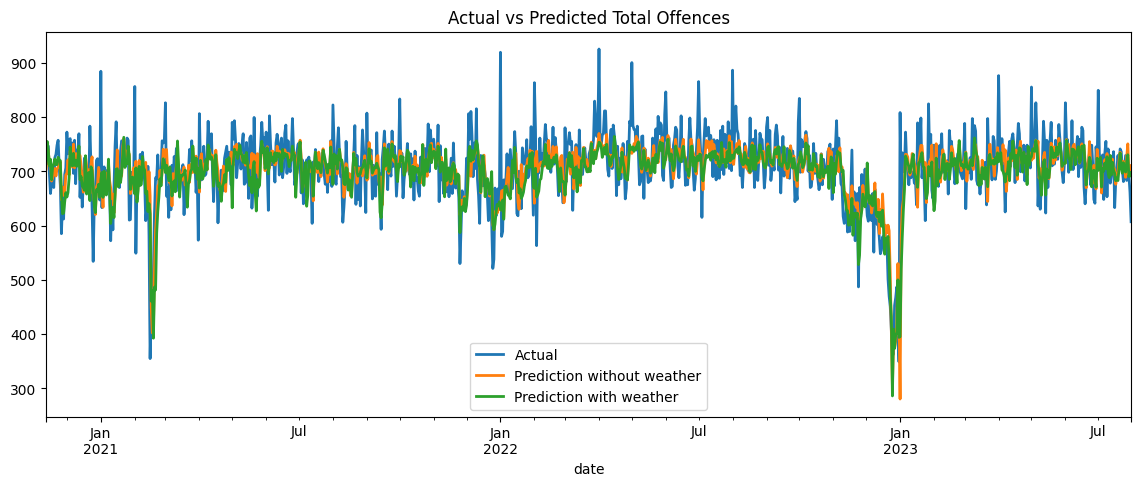

In [1362]:
figure, ax = plt.subplots(figsize=(14, 5))
df_test = pd.DataFrame({"date": test_without_weather.index, "actual": y_test, 
                        "pred_without_weather": pred_without_weather, "pred_with_weather": pred_with_weather })
df_test.plot(ax=ax, label="Actual", x="date", y="actual", linewidth=2)
df_test.plot(ax=ax, label="Prediction without weather", x="date", y="pred_without_weather", linewidth=2)
df_test.plot(ax=ax, label="Prediction with weather", x="date", y="pred_with_weather", linewidth=2)
plt.legend(["Actual", "Prediction without weather", "Prediction with weather"])
ax.set_title("Actual vs Predicted Total Offences")
plt.show()

### Explain predictions

In [1363]:
import shap

# compute SHAP values
explainer = shap.Explainer(grid_search.best_estimator_, train)
shap_values = explainer(train)

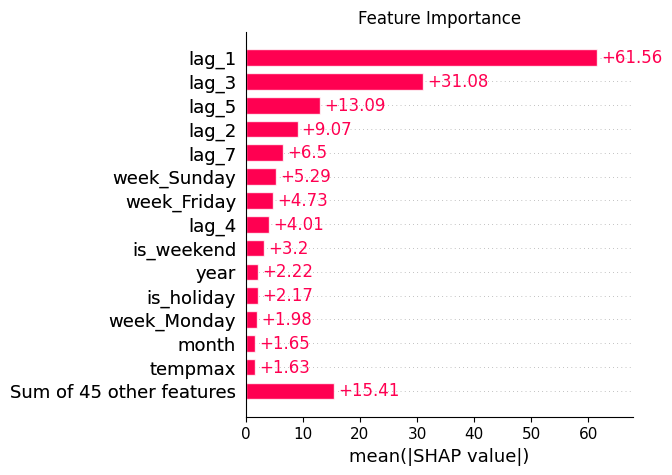

In [1364]:
# most important features computed and plotted using the SHAP library
shap.plots.bar(shap_values, max_display=15, show=False)

plt.title('Feature Importance')
plt.gcf().set_size_inches(5,5)
plt.show()

In [1365]:
def plot_feature_importance(df_feat_imp):
    df_feat_imp = df_feat_imp.T.sort_values(0)

    ax = df_feat_imp.tail(15).plot(kind='barh', figsize=(6, 6), width=.7, color="#008BFB")
    ax.set_title("Feature Importance")
    ax.bar_label(ax.containers[0], padding=5)
    ax.legend().remove()

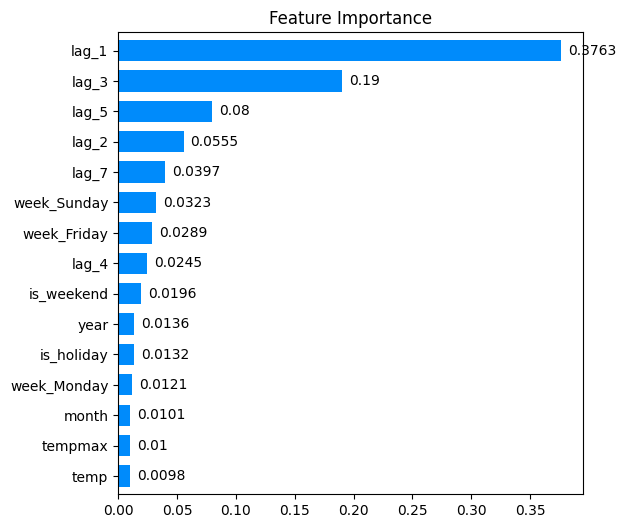

In [1366]:
# compute feature imporance as a percentage
feature_importance = abs(shap_values.values).sum(axis=0) / abs(shap_values.values).sum()
feature_names = train.columns
df_feat_imp = pd.DataFrame([np.round(feature_importance, 4)], columns=feature_names)

plot_feature_importance(df_feat_imp)

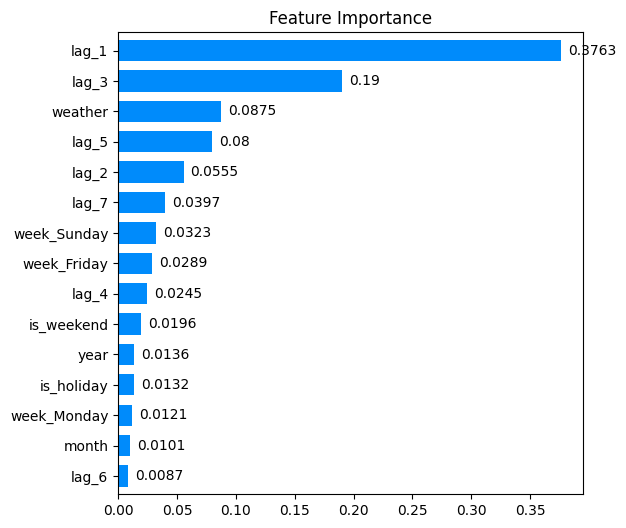

In [1367]:
# group together weather features
weather_features = ['tempmax', 'tempmin',
       'temp', 'feelslikemax', 'feelslikemin', 'feelslike', 'humidity',
       'precip', 'precipcover', 'windspeed',
       'sealevelpressure', 'cloudcover', 'visibility', 'solarradiation',
       'solarenergy', 'uvindex', 'moonphase']

df_feat_imp['weather_1'] = df_feat_imp[weather_features].sum(axis=1)
df_feat_imp.drop(columns=weather_features, inplace=True)

df_feat_imp['weather_2'] = df_feat_imp[[col for col in df_feat_imp.columns if 
                                        (col.startswith('icon_') or col.startswith('preciptype_') or col.startswith('conditions_'))
                                        ]].sum(axis=1)
df_feat_imp = df_feat_imp.loc[:, ~df_feat_imp.columns.str.startswith('icon_')]
df_feat_imp = df_feat_imp.loc[:, ~df_feat_imp.columns.str.startswith('preciptype_')]
df_feat_imp = df_feat_imp.loc[:, ~df_feat_imp.columns.str.startswith('conditions_')]

df_feat_imp['weather'] = df_feat_imp[[col for col in df_feat_imp.columns if col.startswith('weather_')]].sum(axis=1)
df_feat_imp = df_feat_imp.loc[:, ~df_feat_imp.columns.str.startswith('weather_')]

plot_feature_importance(df_feat_imp)

## Analysis of different offense types and how weather affects them

Consider the top 8 crime types by count, for better consistancy.

In [1368]:
top_offenses_by_count = y_train_all.sum(axis=0).sort_values(ascending=False)
top_offenses_by_count.drop(labels=['Offense Count', 'All Other Offenses'], inplace=True)
top_offenses_by_count = top_offenses_by_count[:8]

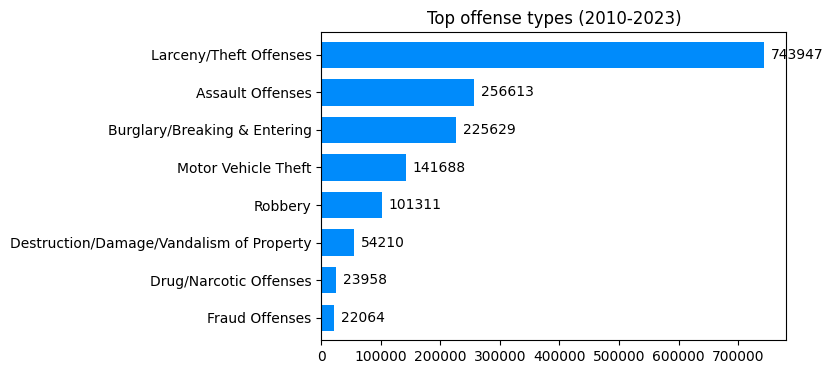

In [1369]:
# display top offenses
ax = top_offenses_by_count.sort_values().plot(kind='barh', figsize=(6, 4), width=.7, color="#008BFB")
ax.set_title("Top offense types (2010-2023)")
ax.bar_label(ax.containers[0], padding=5)
plt.show()

### Compute how weather conditions affect each of the top offenses

In [1370]:
# compute how weather factors affect different offenses
weather_importance_by_offence = {}
pred_by_offence = {}
shap_values_by_offense = {}
feature_importance_all = {}
feature_importance_weather = {}

for offense, _ in top_offenses_by_count.items():
    # pick one target value
    y_train = y_train_all[offense].values
    y_test = y_test_all[offense].values

    # train model
    model = lgb.LGBMRegressor()
    parameters = {
        "max_depth": [3, 4, 5],
        "num_leaves": [10, 20, 30],
        "learning_rate": [0.01, 0.05, 0.1, 0.2],
        "n_estimators": [50, 100],
        "colsample_bytree": [0.5, 0.7, 1]
    }
    grid_search = GridSearchCV(estimator=model, cv=cv_split, param_grid=parameters)
    grid_search.fit(X_train, y_train)

    # save preditions
    pred_by_offence[offense] = grid_search.predict(X_test)

    # compute SHAP values
    explainer = shap.Explainer(grid_search.best_estimator_, train)
    shap_values = explainer(train)

    # save SHAP values
    shap_values_by_offense[offense] = shap_values

    # compute feature imporance as a percentage
    feature_importance = abs(shap_values.values).sum(axis=0) / abs(shap_values.values).sum()
    feature_names = train.columns
    df_feat_imp = pd.DataFrame([np.round(feature_importance, 4)], columns=feature_names)

    feature_importance_all[offense] = df_feat_imp.copy()

    # group together weather features
    df_feat_imp['weather_1'] = df_feat_imp[weather_features].sum(axis=1)
    df_feat_imp.drop(columns=weather_features, inplace=True)

    df_feat_imp['weather_2'] = df_feat_imp[[col for col in df_feat_imp.columns if 
                                            (col.startswith('icon_') or col.startswith('preciptype_') or col.startswith('conditions_'))
                                            ]].sum(axis=1)
    df_feat_imp = df_feat_imp.loc[:, ~df_feat_imp.columns.str.startswith('icon_')]
    df_feat_imp = df_feat_imp.loc[:, ~df_feat_imp.columns.str.startswith('preciptype_')]
    df_feat_imp = df_feat_imp.loc[:, ~df_feat_imp.columns.str.startswith('conditions_')]

    df_feat_imp['weather'] = df_feat_imp[[col for col in df_feat_imp.columns if col.startswith('weather_')]].sum(axis=1)
    df_feat_imp = df_feat_imp.loc[:, ~df_feat_imp.columns.str.startswith('weather_')]

    # save feature importance
    feature_importance_weather[offense] = df_feat_imp.copy()

    weather_importance_by_offence[offense] = df_feat_imp['weather'][0]

 98%|===================| 3871/3968 [00:13<00:00]        

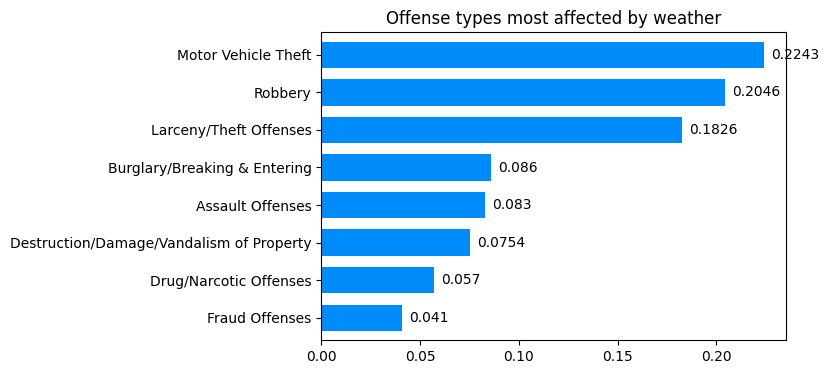

In [1371]:
# display offenses most affected by weather
ax = pd.DataFrame.from_dict([weather_importance_by_offence]).T.sort_values(0).plot(kind='barh', figsize=(6, 4), width=.7, color="#008BFB")
ax.set_title("Offense types most affected by weather")
ax.bar_label(ax.containers[0], padding=5)
ax.legend().remove()
plt.show()

### Actual vs Predicted values for the Top Offenses

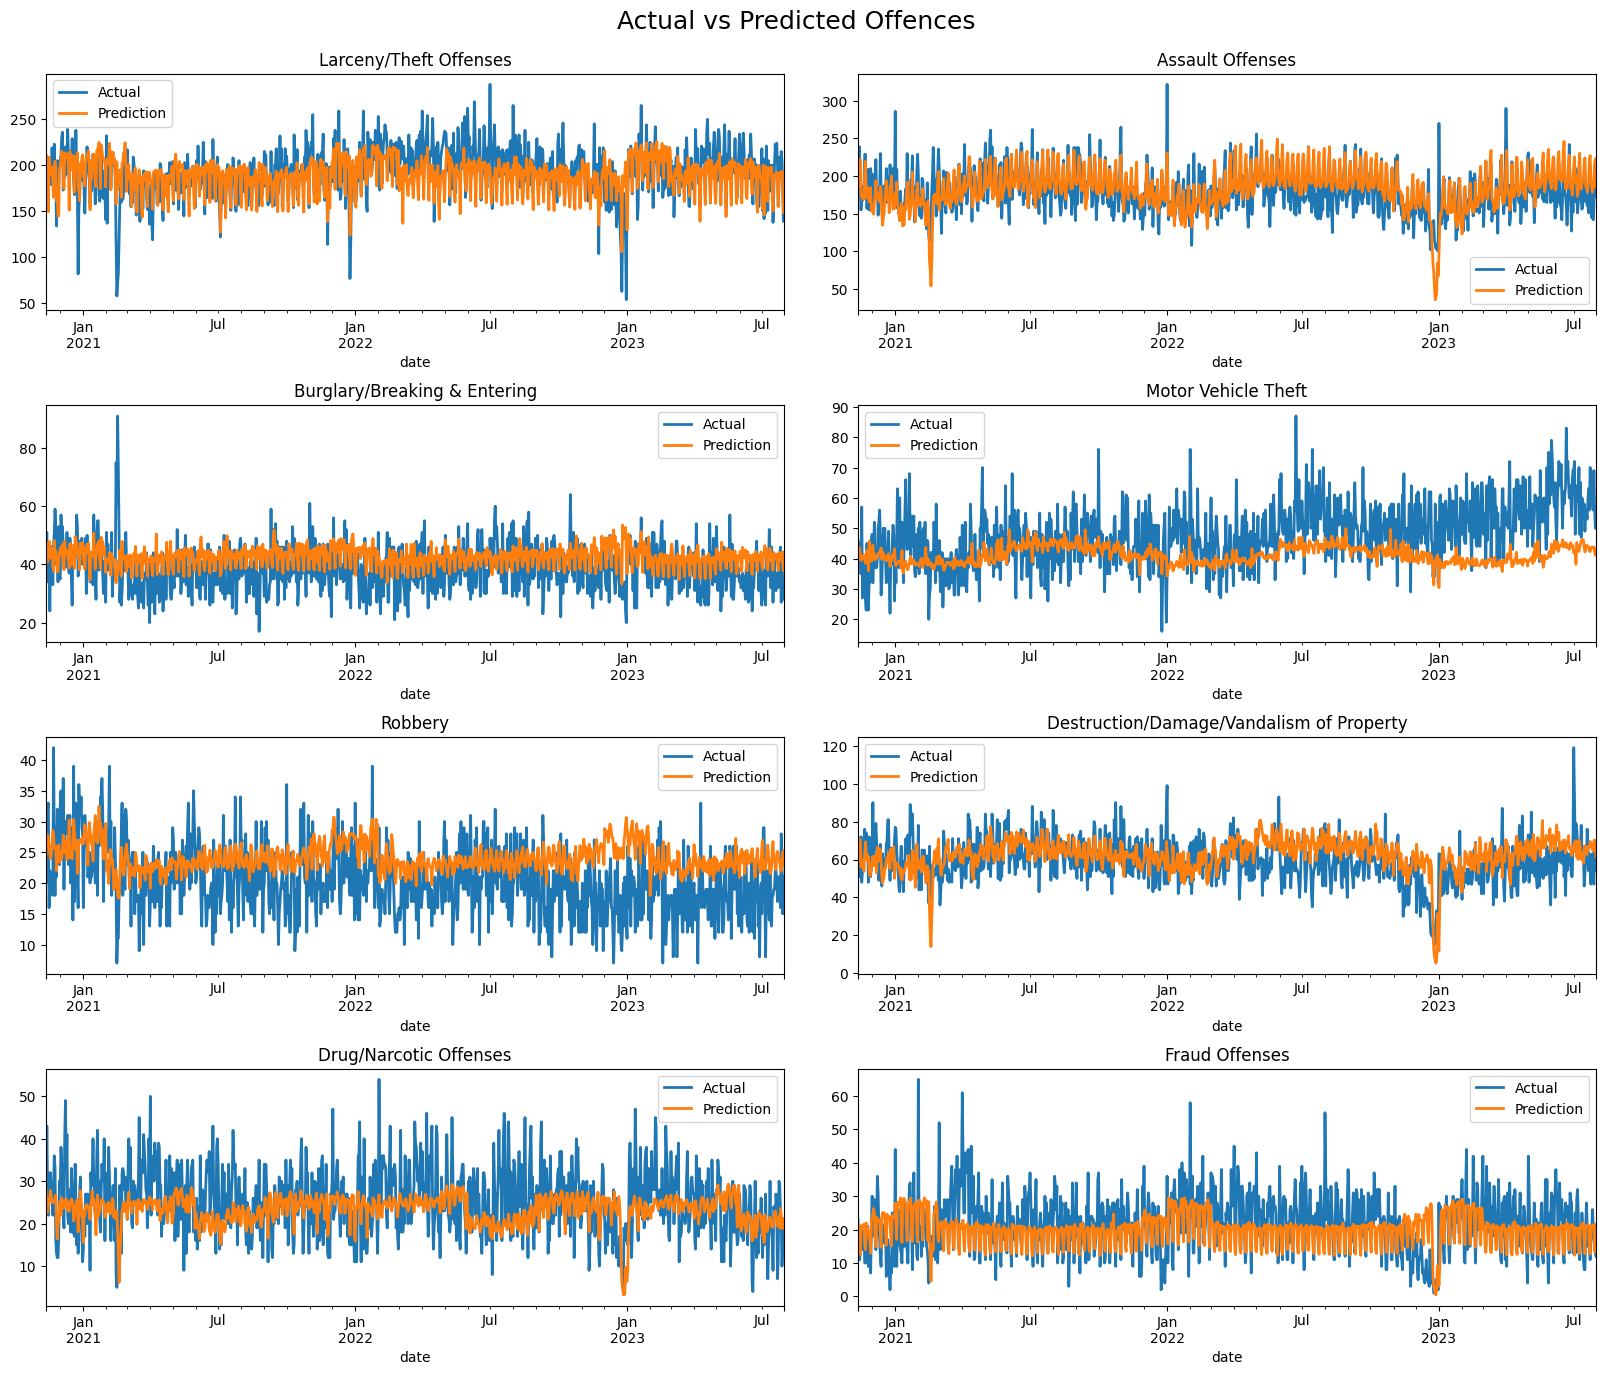

In [1372]:
# plot predicted values for the top offenses
nrow = 4
ncol = 2
fig, axs = plt.subplots(nrow, ncol, figsize=(20, 16))
plt.subplots_adjust(hspace=0.4, wspace=.1)
fig.suptitle("Actual vs Predicted Offences", fontsize=18, y=0.92)

i=0
for offense, _ in top_offenses_by_count.items():
    pred = pred_by_offence[offense]
    y_test = y_test_all[offense].values
    plot_predictions(offense, fig.axes[i], test.index, y_test, pred)
    i+=1

plt.show()

### Feature importance breakdown for the Top Offenses

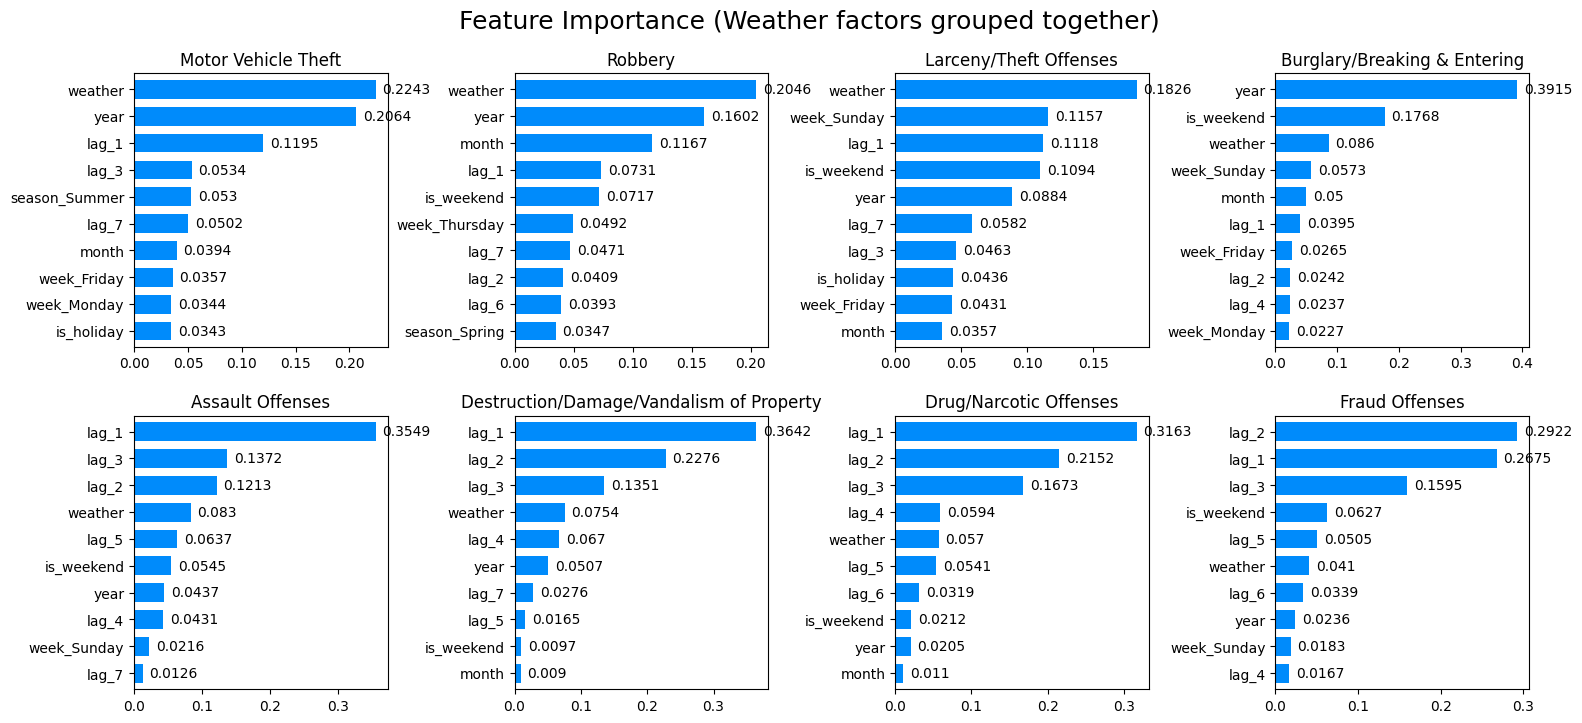

In [1373]:
# plot most important features (having weather conditions grouped together) for the top offenses
nrow = 2
ncol = 4
fig, axs = plt.subplots(nrow, ncol, figsize=(18, 8))
plt.subplots_adjust(hspace=0.25, wspace=.5)
fig.suptitle("Feature Importance (Weather factors grouped together)", fontsize=18, y=0.96)

i=0
for offense, _ in dict(sorted(weather_importance_by_offence.items(), key=lambda x:x[1], reverse=True)).items():
    
    df_feat_imp = feature_importance_weather[offense].T.sort_values(0)
    ax = df_feat_imp.tail(10).plot(kind='barh', ax=fig.axes[i], width=.7, color="#008BFB")
    ax.set_title(offense)
    ax.bar_label(ax.containers[0], padding=5)
    ax.legend().remove()
    i+=1

plt.show()

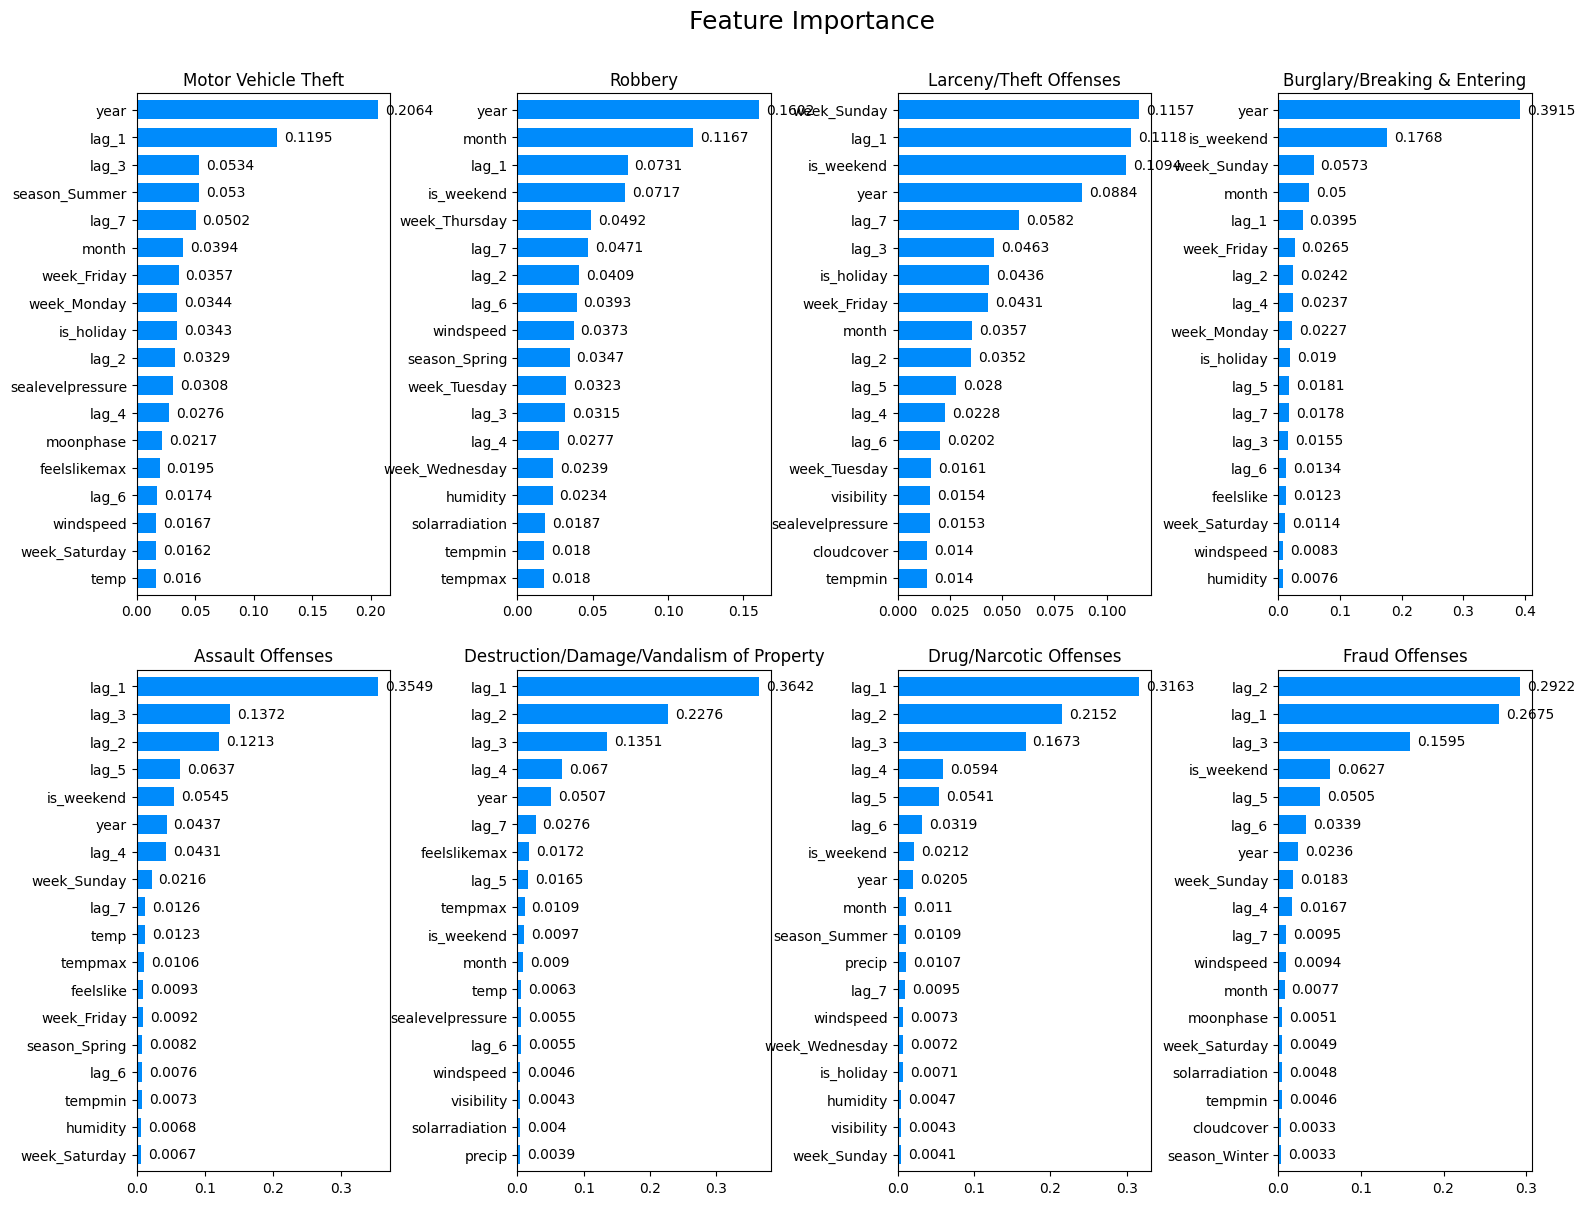

In [1374]:
# plot most important features (having weather conditions grouped together) for the top offenses
nrow = 2
ncol = 4
fig, axs = plt.subplots(nrow, ncol, figsize=(18, 14))
plt.subplots_adjust(hspace=0.15, wspace=.5)
fig.suptitle("Feature Importance", fontsize=18, y=0.94)

i=0
for offense, _ in dict(sorted(weather_importance_by_offence.items(), key=lambda x:x[1], reverse=True)).items():
    
    df_feat_imp = feature_importance_all[offense].T.sort_values(0)
    ax = df_feat_imp.tail(18).plot(kind='barh', ax=fig.axes[i], width=.7, color="#008BFB")
    ax.set_title(offense)
    ax.bar_label(ax.containers[0], padding=5)
    ax.legend().remove()
    i+=1

plt.show()

## Motor Vehicle Theft

In [1375]:
y_train = y_train_all['Motor Vehicle Theft'].values
y_test = y_test_all['Motor Vehicle Theft'].values

### Training without weather features

In [1376]:
# LGBM
cv_split = TimeSeriesSplit(n_splits=4, test_size=100)
model = lgb.LGBMRegressor()
parameters = {
    "max_depth": [5, 6, 7, 8],
    "num_leaves": [10, 20, 30, 40],
    "learning_rate": [0.05, 0.1, 0.2],
    "n_estimators": [30, 40, 50, 100],
    "colsample_bytree": [0.5, 0.7, 1]
}

grid_search = GridSearchCV(estimator=model, cv=cv_split, param_grid=parameters)
grid_search.fit(X_train_without_weather, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=4, test_size=100),
             estimator=LGBMRegressor(),
             param_grid={'colsample_bytree': [0.5, 0.7, 1],
                         'learning_rate': [0.05, 0.1, 0.2],
                         'max_depth': [5, 6, 7, 8],
                         'n_estimators': [30, 40, 50, 100],
                         'num_leaves': [10, 20, 30, 40]})

### Evaluation

In [1378]:
# Evaluating GridSearch results
pred_without_weather = grid_search.predict(X_test_without_weather)
evaluation_without_weather = evaluate_model(y_test, pred_without_weather)
evaluation_without_weather.index = ["Model without weather"]

### Training with weather features

In [1379]:
# LGBM
cv_split = TimeSeriesSplit(n_splits=4, test_size=100)
model = lgb.LGBMRegressor()
parameters = {
    "max_depth": [5, 6, 7, 8],
    "num_leaves": [10, 20, 30, 40],
    "learning_rate": [0.05, 0.1, 0.2],
    "n_estimators": [30, 40, 50, 100],
    "colsample_bytree": [0.5, 0.7, 1]
}

grid_search = GridSearchCV(estimator=model, cv=cv_split, param_grid=parameters)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=4, test_size=100),
             estimator=LGBMRegressor(),
             param_grid={'colsample_bytree': [0.5, 0.7, 1],
                         'learning_rate': [0.05, 0.1, 0.2],
                         'max_depth': [5, 6, 7, 8],
                         'n_estimators': [30, 40, 50, 100],
                         'num_leaves': [10, 20, 30, 40]})

### Evaluation

In [1381]:
# Evaluating GridSearch results
pred_with_weather = grid_search.predict(X_test)
evaluation_with_weather = evaluate_model(y_test, pred_with_weather)
evaluation_with_weather.index = ["Model with weather"]

### Model performance with/without weather features

In [1382]:
pd.concat([evaluation_without_weather, evaluation_with_weather], axis=0)

,MAE,MSE,MAPE,RMSE
Model without weather,9.441792,143.048164,0.188495,11.960274
Model with weather,9.539048,145.521475,0.189800,12.063228


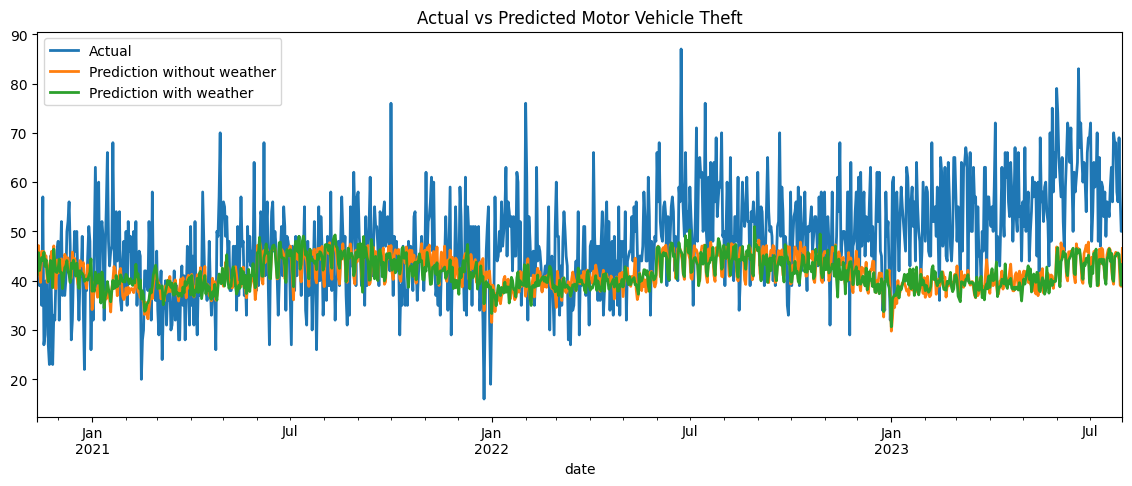

In [1383]:
figure, ax = plt.subplots(figsize=(14, 5))
df_test = pd.DataFrame({"date": test_without_weather.index, "actual": y_test, 
                        "pred_without_weather": pred_without_weather, "pred_with_weather": pred_with_weather })
df_test.plot(ax=ax, label="Actual", x="date", y="actual", linewidth=2)
df_test.plot(ax=ax, label="Prediction without weather", x="date", y="pred_without_weather", linewidth=2)
df_test.plot(ax=ax, label="Prediction with weather", x="date", y="pred_with_weather", linewidth=2)
plt.legend(["Actual", "Prediction without weather", "Prediction with weather"])
ax.set_title("Actual vs Predicted Motor Vehicle Theft")
plt.show()

 98%|===================| 3901/3968 [00:12<00:00]        No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


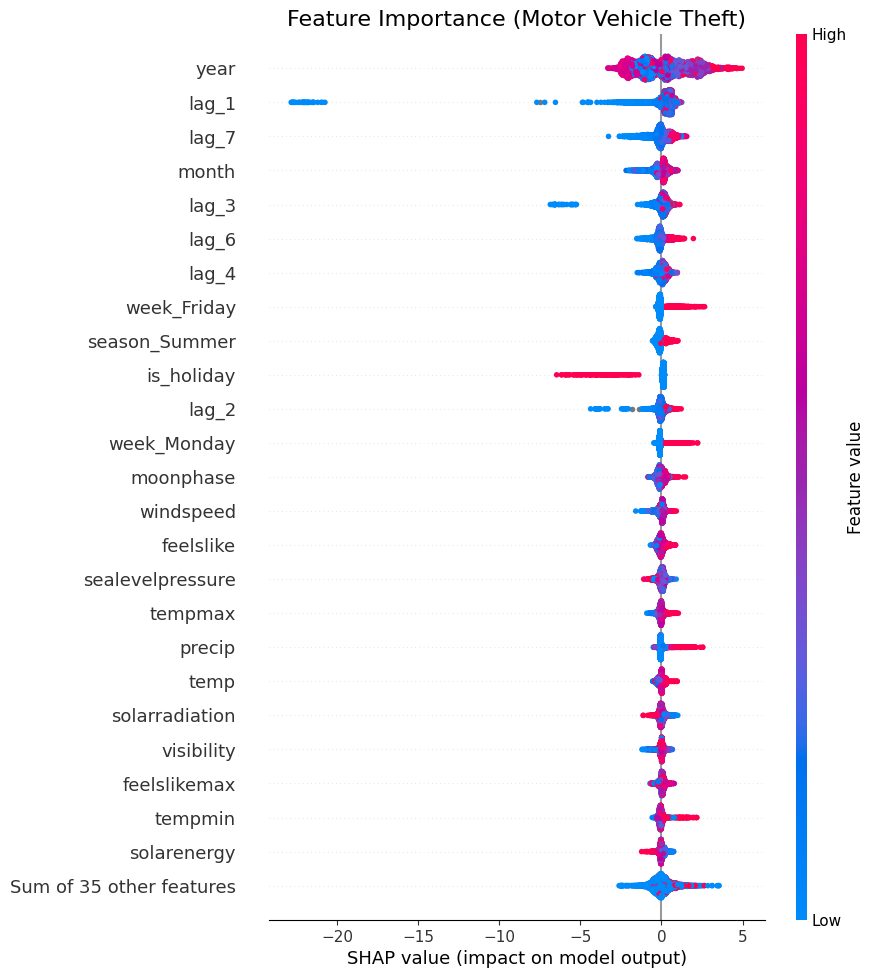

In [1384]:
explainer = shap.Explainer(grid_search.best_estimator_, train)
shap_values = explainer(train)

shap.plots.beeswarm(shap_values, max_display=25, show=False)
plt.title('Feature Importance (Motor Vehicle Theft)', size=16)
plt.show()

## Larceny/Theft Offenses

In [1385]:
y_train = y_train_all['Larceny/Theft Offenses'].values
y_test = y_test_all['Larceny/Theft Offenses'].values

### Training without weather features

In [1386]:
# LGBM
cv_split = TimeSeriesSplit(n_splits=4, test_size=100)
model = lgb.LGBMRegressor()
parameters = {
    "max_depth": [5, 6, 7, 8],
    "num_leaves": [30, 40, 50],
    "learning_rate": [0.1, 0.2, 0.5],
    "n_estimators": [50, 100, 120],
    "colsample_bytree": [0.5, 0.7, 1]
}

grid_search = GridSearchCV(estimator=model, cv=cv_split, param_grid=parameters)
grid_search.fit(X_train_without_weather, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=4, test_size=100),
             estimator=LGBMRegressor(),
             param_grid={'colsample_bytree': [0.5, 0.7, 1],
                         'learning_rate': [0.1, 0.2, 0.5],
                         'max_depth': [5, 6, 7, 8],
                         'n_estimators': [50, 100, 120],
                         'num_leaves': [30, 40, 50]})

### Evaluation

In [1388]:
# Evaluating GridSearch results
pred_without_weather = grid_search.predict(X_test_without_weather)
evaluation_without_weather = evaluate_model(y_test, pred_without_weather)
evaluation_without_weather.index = ["Model without weather"]

### Training with weather features

In [1389]:
# LGBM
cv_split = TimeSeriesSplit(n_splits=4, test_size=100)
model = lgb.LGBMRegressor()
parameters = {
    "max_depth": [4, 5, 6, 7],
    "num_leaves": [10, 20, 30, 40],
    "learning_rate": [0.1, 0.2, 0.5],
    "n_estimators": [50, 100, 120],
    "colsample_bytree": [0.5, 0.7, 1]
}

grid_search = GridSearchCV(estimator=model, cv=cv_split, param_grid=parameters)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=4, test_size=100),
             estimator=LGBMRegressor(),
             param_grid={'colsample_bytree': [0.5, 0.7, 1],
                         'learning_rate': [0.1, 0.2, 0.5],
                         'max_depth': [4, 5, 6, 7],
                         'n_estimators': [50, 100, 120],
                         'num_leaves': [10, 20, 30, 40]})

### Evaluation

In [1391]:
# Evaluating GridSearch results
pred_with_weather = grid_search.predict(X_test)
evaluation_with_weather = evaluate_model(y_test, pred_with_weather)
evaluation_with_weather.index = ["Model with weather"]

### Model performance with/without weather features

In [1392]:
pd.concat([evaluation_without_weather, evaluation_with_weather], axis=0)

,MAE,MSE,MAPE,RMSE
Model without weather,19.252120,641.000607,0.107504,25.317990
Model with weather,19.068463,625.700443,0.106403,25.014005


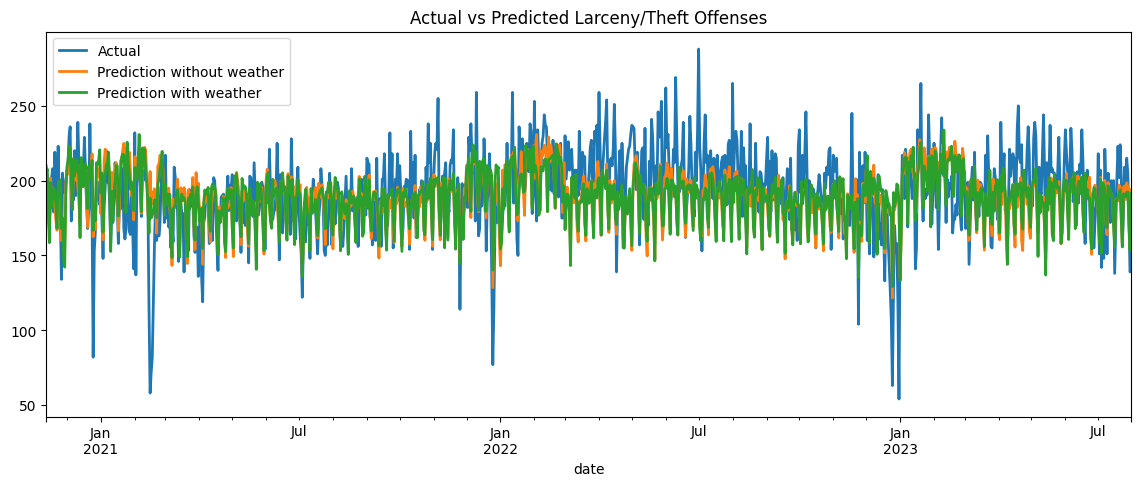

In [1393]:
figure, ax = plt.subplots(figsize=(14, 5))
df_test = pd.DataFrame({"date": test_without_weather.index, "actual": y_test, 
                        "pred_without_weather": pred_without_weather, "pred_with_weather": pred_with_weather })
df_test.plot(ax=ax, label="Actual", x="date", y="actual", linewidth=2)
df_test.plot(ax=ax, label="Prediction without weather", x="date", y="pred_without_weather", linewidth=2)
df_test.plot(ax=ax, label="Prediction with weather", x="date", y="pred_with_weather", linewidth=2)
plt.legend(["Actual", "Prediction without weather", "Prediction with weather"])
ax.set_title("Actual vs Predicted Larceny/Theft Offenses")
plt.show()

 97%|=================== | 3833/3968 [00:24<00:00]       No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


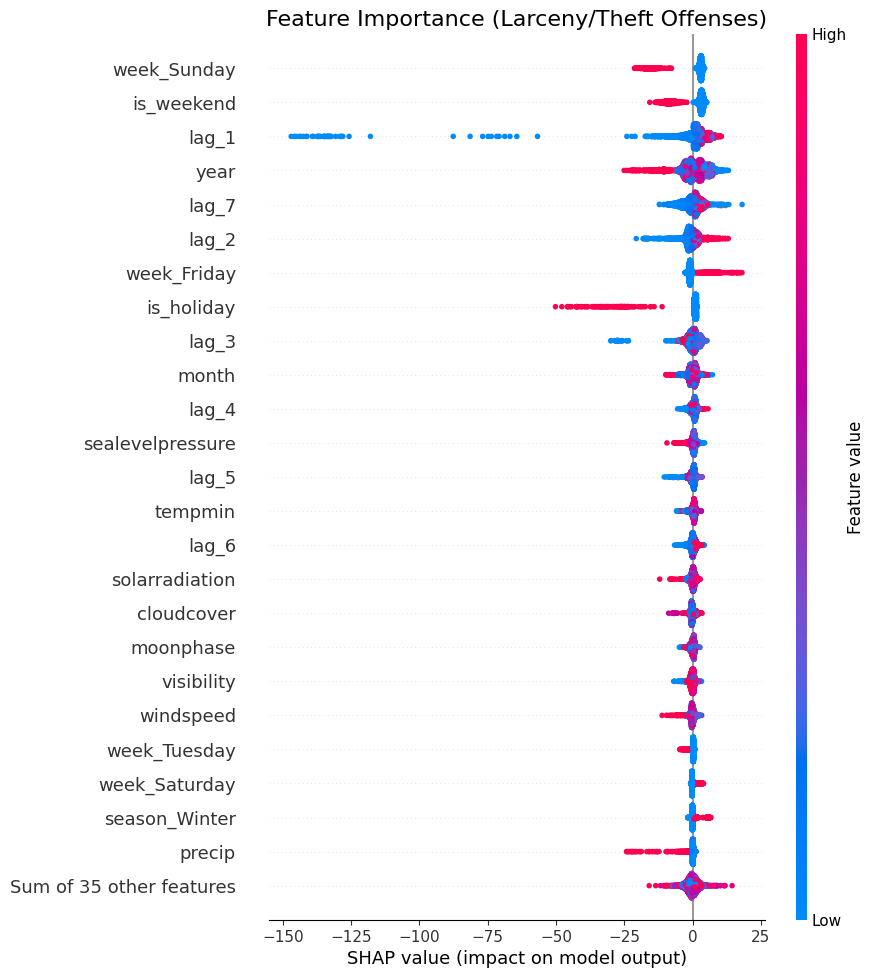

In [1394]:
explainer = shap.Explainer(grid_search.best_estimator_, train)
shap_values = explainer(train)

shap.plots.beeswarm(shap_values, max_display=25, show=False)
plt.title('Feature Importance (Larceny/Theft Offenses)', size=16)
plt.show()

## Assault Offenses

In [1395]:
y_train = y_train_all['Assault Offenses'].values
y_test = y_test_all['Assault Offenses'].values

### Training without weather features

In [1396]:
# LGBM
cv_split = TimeSeriesSplit(n_splits=4, test_size=100)
model = lgb.LGBMRegressor()
parameters = {
    "max_depth": [5, 6, 7, 8],
    "num_leaves": [10, 20, 30, 40],
    "learning_rate": [0.05, 0.1, 0.2],
    "n_estimators": [30, 40, 50, 100],
    "colsample_bytree": [0.5, 0.7, 1]
}

grid_search = GridSearchCV(estimator=model, cv=cv_split, param_grid=parameters)
grid_search.fit(X_train_without_weather, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=4, test_size=100),
             estimator=LGBMRegressor(),
             param_grid={'colsample_bytree': [0.5, 0.7, 1],
                         'learning_rate': [0.05, 0.1, 0.2],
                         'max_depth': [5, 6, 7, 8],
                         'n_estimators': [30, 40, 50, 100],
                         'num_leaves': [10, 20, 30, 40]})

### Evaluation

In [1398]:
# Evaluating GridSearch results
pred_without_weather = grid_search.predict(X_test_without_weather)
evaluation_without_weather = evaluate_model(y_test, pred_without_weather)
evaluation_without_weather.index = ["Model without weather"]

### Training with weather features

In [1399]:
# LGBM
cv_split = TimeSeriesSplit(n_splits=4, test_size=100)
model = lgb.LGBMRegressor()
parameters = {
    "max_depth": [5, 6, 7, 8],
    "num_leaves": [10, 20, 30, 40],
    "learning_rate": [0.05, 0.1, 0.2],
    "n_estimators": [30, 40, 50, 100],
    "colsample_bytree": [0.5, 0.7, 1]
}

grid_search = GridSearchCV(estimator=model, cv=cv_split, param_grid=parameters)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=4, test_size=100),
             estimator=LGBMRegressor(),
             param_grid={'colsample_bytree': [0.5, 0.7, 1],
                         'learning_rate': [0.05, 0.1, 0.2],
                         'max_depth': [5, 6, 7, 8],
                         'n_estimators': [30, 40, 50, 100],
                         'num_leaves': [10, 20, 30, 40]})

### Evaluation

In [1401]:
# Evaluating GridSearch results
pred_with_weather = grid_search.predict(X_test)
evaluation_with_weather = evaluate_model(y_test, pred_with_weather)
evaluation_with_weather.index = ["Model with weather"]

### Model performance with/without weather features

In [1402]:
pd.concat([evaluation_without_weather, evaluation_with_weather], axis=0)

,MAE,MSE,MAPE,RMSE
Model without weather,19.754046,636.842318,0.115804,25.235735
Model with weather,18.548836,584.263832,0.107784,24.171550


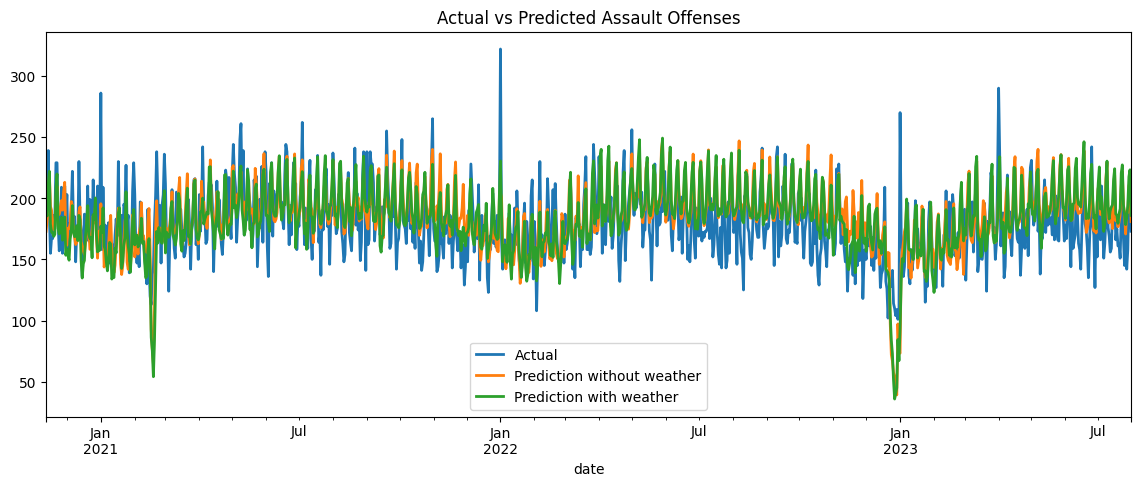

In [1403]:
figure, ax = plt.subplots(figsize=(14, 5))
df_test = pd.DataFrame({"date": test_without_weather.index, "actual": y_test, 
                        "pred_without_weather": pred_without_weather, "pred_with_weather": pred_with_weather })
df_test.plot(ax=ax, label="Actual", x="date", y="actual", linewidth=2)
df_test.plot(ax=ax, label="Prediction without weather", x="date", y="pred_without_weather", linewidth=2)
df_test.plot(ax=ax, label="Prediction with weather", x="date", y="pred_with_weather", linewidth=2)
plt.legend(["Actual", "Prediction without weather", "Prediction with weather"])
ax.set_title("Actual vs Predicted Assault Offenses")
plt.show()

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


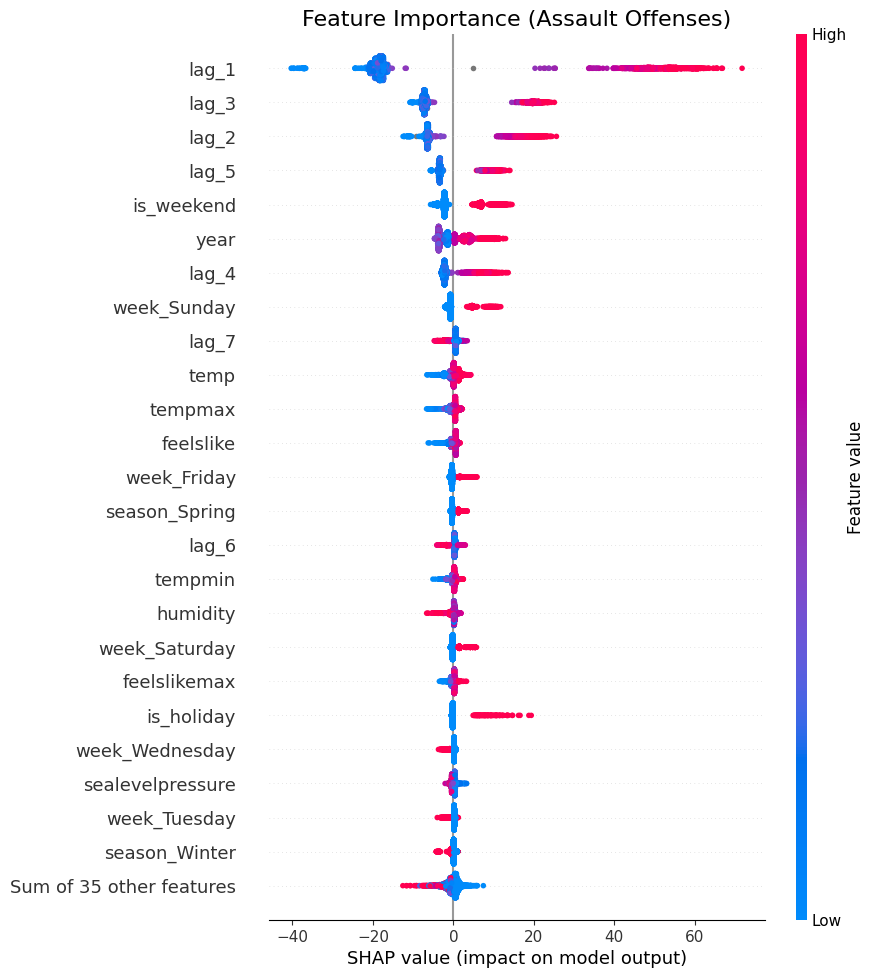

In [1404]:
explainer = shap.Explainer(grid_search.best_estimator_, train)
shap_values = explainer(train)

shap.plots.beeswarm(shap_values, max_display=25, show=False)
plt.title('Feature Importance (Assault Offenses)', size=16)
plt.show()